All required libraries are already installed.
All libraries are ready. Please restart the kernel (↻ button) before proceeding.
All libraries imported successfully.
Dataset 'parkinsons_data' (drawings_1.zip) already exists.
Dataset 'parkinsons_multimodal_data' (combined_dastaset_1.zip) already exists.
Dataset 'parkinsons_data_3' (drawings_2.zip) already exists.
Dataset 'parkinsons_data_4' (drawings_3.zip) already exists.

Loading dataset 1...
Found 102 images from dataset 1.

Loading dataset 2...
Found 204 images from dataset 2.

Loading dataset 3...
Found 3264 images from dataset 3.

Loading dataset 4...
Found 102 images from dataset 4.

Total combined images from all four datasets: 3672
Total data: 3672 images
Training set: 2349 images
Validation set: 588 images
Final Test set: 735 images

--- Training Final Model (Monitored by Validation Set) ---

--- Phase 1: Training classifier head ---
Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.7429 - loss: 1.0097 - val_accur

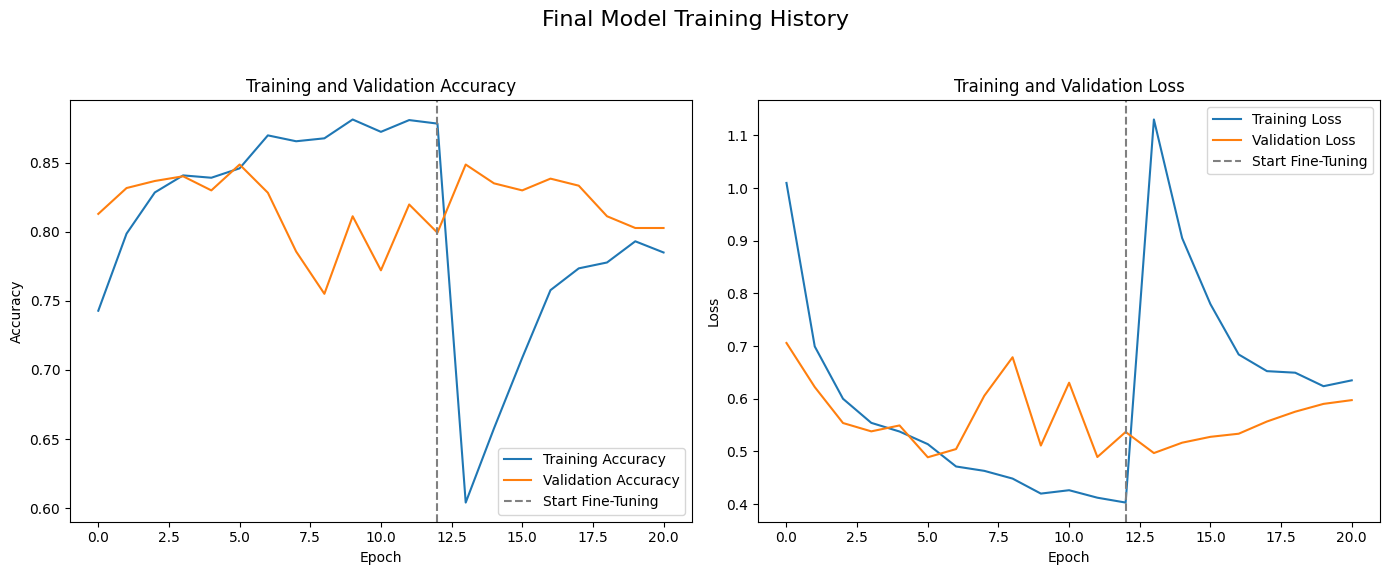

In [1]:
# --- 1. NEW: INSTALL REQUIRED LIBRARIES ---
import subprocess
import sys
import os 
import zipfile 

try:
    # Check for all required libraries
    import tensorflow
    import sklearn
    import numpy
    import matplotlib
    print("All required libraries are already installed.")
except ImportError:
    print("Installing required libraries: tensorflow, scikit-learn, numpy, matplotlib")
    # Install all dependencies at once
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow", "scikit-learn", "numpy", "matplotlib"])

print("All libraries are ready. Please restart the kernel (↻ button) before proceeding.")


# --- 2. IMPORT LIBRARIES ---
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201 # <-- NEW MODEL
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import matplotlib.pyplot as plt
import zipfile
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
print("All libraries imported successfully.")

# --- 3. SETUP CELL: UNZIP ALL FOUR DATASETS ---
zip_path_1 = '../drawings_1.zip' 
data_dir_1 = 'parkinsons_data'
if not os.path.exists(data_dir_1):
    print(f"Unzipping '{zip_path_1}'...")
    with zipfile.ZipFile(zip_path_1, 'r') as zip_ref:
        zip_ref.extractall(data_dir_1)
else:
    print(f"Dataset '{data_dir_1}' (drawings_1.zip) already exists.")

zip_path_2 = '../combined_dastaset_1.zip' 
data_dir_2 = 'parkinsons_multimodal_data'
if not os.path.exists(data_dir_2):
    print(f"Unzipping '{zip_path_2}'...")
    with zipfile.ZipFile(zip_path_2, 'r') as zip_ref:
        zip_ref.extractall(data_dir_2)
else:
    print(f"Dataset '{data_dir_2}' (combined_dastaset_1.zip) already exists.")

zip_path_3 = '../drawings_2.zip'
data_dir_3 = 'parkinsons_data_3'
if not os.path.exists(data_dir_3):
    print(f"Unzipping '{zip_path_3}'...")
    try:
        with zipfile.ZipFile(zip_path_3, 'r') as zip_ref:
            zip_ref.extractall(data_dir_3)
        print(f"Drawings dataset 3 ('{zip_path_3}') unzipped successfully into '{data_dir_3}'.")
    except FileNotFoundError:
        print(f"ERROR: '{zip_path_3}' not found. Please ensure it's in the 'backend' folder.")
else:
    print(f"Dataset '{data_dir_3}' (drawings_2.zip) already exists.")

zip_path_4 = '../drawings_3.zip' 
data_dir_4 = 'parkinsons_data_4' 
if not os.path.exists(data_dir_4):
    print(f"Unzipping '{zip_path_4}'...")
    try:
        with zipfile.ZipFile(zip_path_4, 'r') as zip_ref:
            zip_ref.extractall(data_dir_4)
        print(f"Drawings dataset 4 ('{zip_path_4}') unzipped successfully into '{data_dir_4}'.")
    except FileNotFoundError:
        print(f"ERROR: '{zip_path_4}' not found. Please ensure it's in the 'backend' folder.")
else:
    print(f"Dataset '{data_dir_4}' (drawings_3.zip) already exists.")


# --- 4. DATA AGGREGATION CELL: COMBINE ALL FOUR DATASETS ---
all_image_paths = []
all_labels = []

# Load from dataset 1 (drawings_1.zip)
print("\nLoading dataset 1...")
ds1_base_path = 'parkinsons_data'
ds1_folders = ['drawings/spiral/training/healthy', 'drawings/spiral/training/parkinson', 'drawings/spiral/testing/healthy', 'drawings/spiral/testing/parkinson'] 
initial_count_ds1 = len(all_image_paths)
for folder in ds1_folders:
    label = 0 if 'healthy' in folder else 1
    full_path = os.path.join(ds1_base_path, folder)
    if os.path.exists(full_path):
        for filename in os.listdir(full_path):
            all_image_paths.append(os.path.join(full_path, filename))
            all_labels.append(label)
print(f"Found {len(all_image_paths) - initial_count_ds1} images from dataset 1.")

# Load from dataset 2 (combined_dastaset_1.zip)
print("\nLoading dataset 2...")
ds2_base_path = os.path.join(data_dir_2, 'Parkinson Multi Model DATASET')
class_map_ds2 = {"Healthy": 0, "Unhealthy": 1}
drawing_subfolders = {
    "Healthy": ["Healthy/DRAWING 1 HEALTHY (S)", "Healthy/DRAWING 1 HEALTHY (W)", "Healthy/DRAWING 2 HEALTHY (S)", "Healthy/DRAWING 2 HEALTHY (W)"], 
    "Unhealthy": ["Unhealthy/DRAWING 1 UNHEALTHY (S)", "Unhealthy/DRAWING 1 UNHEALTHY (W)", "Unhealthy/DRAWING 2 UNHEALTHY (S)", "Unhealthy/DRAWING 2 UNHEALTHY (W)"] 
}
initial_count_ds2 = len(all_image_paths)
for class_name, label in class_map_ds2.items():
    for folder in drawing_subfolders[class_name]:
        folder_path = os.path.join(ds2_base_path, folder)
        if os.path.exists(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_image_paths.append(os.path.join(folder_path, filename))
                    all_labels.append(label)
print(f"Found {len(all_image_paths) - initial_count_ds2} images from dataset 2.")

# Load from dataset 3 (drawings_2.zip - 'augmented-hand-drawn-data')
print("\nLoading dataset 3...")
ds3_base_path = data_dir_3 
ds3_folders_to_load = {
    'Dataset/Dataset/Healthy': 0,   # path: label
    'Dataset/Dataset/Parkinson': 1  # path: label
}
initial_count_ds3 = len(all_image_paths)
for folder, label in ds3_folders_to_load.items():
    full_path = os.path.join(ds3_base_path, folder)
    if os.path.exists(full_path):
        for filename in os.listdir(full_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_paths.append(os.path.join(full_path, filename))
                all_labels.append(label)
    else:
        print(f"WARNING: Dataset 3 folder not found at: {full_path}")
print(f"Found {len(all_image_paths) - initial_count_ds3} images from dataset 3.")

# Load from dataset 4 (drawings_3.zip - 'dhiaeddinear/parkinson-drawings')
print("\nLoading dataset 4...")
ds4_base_path = data_dir_4 
ds4_folders = ['parkinsons-drawings/drawings/spiral/training/healthy', 
               'parkinsons-drawings/drawings/spiral/training/parkinson', 
               'parkinsons-drawings/drawings/spiral/testing/healthy', 
               'parkinsons-drawings/drawings/spiral/testing/parkinson'] 
initial_count_ds4 = len(all_image_paths)
for folder in ds4_folders:
    label = 0 if 'healthy' in folder else 1
    full_path = os.path.join(ds4_base_path, folder)
    if os.path.exists(full_path):
        for filename in os.listdir(full_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_paths.append(os.path.join(full_path, filename))
                all_labels.append(label)
print(f"Found {len(all_image_paths) - initial_count_ds4} images from dataset 4.")


print(f"\nTotal combined images from all four datasets: {len(all_image_paths)}")
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# --- 5. NEW 3-WAY DATA SPLIT ---
train_val_paths, final_test_paths, train_val_labels, final_test_labels = train_test_split(
    all_image_paths, all_labels,
    test_size=0.20, 
    random_state=42,
    stratify=all_labels
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=0.20, 
    random_state=42,
    stratify=train_val_labels
)
print(f"Total data: {len(all_image_paths)} images")
print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Final Test set: {len(final_test_paths)} images")


# --- 6. DEFINE TF DATASET CREATION FUNCTION ---
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    try:
        image = tf.io.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        return image, label
    except tf.errors.InvalidArgumentError:
        print(f"Warning: Skipping corrupted image file: {path}")
        return tf.zeros((IMG_SIZE, IMG_SIZE, 3)), tf.cast(label, tf.int64)

def create_dataset(paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

def create_train_dataset(paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(paths)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset


# --- 7. DEFINE MODEL BUILDING FUNCTION (DenseNet201) ---
def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ], name="data_augmentation")

    # --- NEW ARCHITECTURE: DenseNet201 ---
    base_model = DenseNet201(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    x = data_augmentation(inputs)
    # --- USE DENSENET PREPROCESSING ---
    x = tf.keras.applications.densenet.preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x) 
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model, base_model

# --- 8. NEW: SINGLE, ROBUST TRAINING RUN ---
print("\n--- Training Final Model (Monitored by Validation Set) ---")

# Check if data loading was successful
if len(train_paths) == 0:
     print("="*60)
     print("ERROR: No training images were loaded. Please check the paths in Cell 3.")
     print("="*60)
else:
    train_ds = create_train_dataset(train_paths, train_labels)
    val_ds = create_dataset(val_paths, val_labels)
    final_test_ds = create_dataset(final_test_paths, final_test_labels)

    model, base_model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    early_stopper_1 = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

    print("\n--- Phase 1: Training classifier head ---")
    history = model.fit(
        train_ds,
        epochs=25, 
        validation_data=val_ds,
        callbacks=[early_stopper_1],
        verbose=1
    )

    print("\n--- Phase 2: Starting Fine-Tuning ---")
    base_model.trainable = True
    # Fine-tune a large portion of DenseNet
    for layer in base_model.layers[-50:]: # Unfreeze last 50 layers
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-8)
    early_stopper_2 = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

    start_epoch = len(history.history['loss']) if history.history else 0

    history_fine = model.fit(
        train_ds,
        epochs=start_epoch + 30, 
        initial_epoch=start_epoch,
        validation_data=val_ds,
        callbacks=[lr_scheduler, early_stopper_2],
        verbose=1
    )

    # --- 9. FINAL EVALUATION ON THE HELD-OUT TEST SET ---
    print("\n--- Evaluating Best Model on the Held-Out Test Set ---")
    final_loss, final_accuracy = model.evaluate(final_test_ds, verbose=1)

    print("\n" + "="*60)
    print(f"Final Model Performance on Unseen Test Set (DenseNet201):")
    print(f"Test Accuracy: {final_accuracy * 100:.2f}%")
    print(f"Test Loss: {final_loss:.4f}")
    print("="*60)

    # --- 10. SAVE THE FINAL, BEST MODEL (FIXED) ---
    # FIX: Added include_optimizer=False to prevent 'TrueDivide' error
    model.save('drawings_model.keras')
    print("\nFinal model saved as 'drawings_model.keras'")

    # --- 11. PLOT FINAL MODEL TRAINING HISTORY ---
    final_history_combined = {}
    if history.history and hasattr(history_fine, 'history'):
        all_keys = set(history.history.keys()) | set(history_fine.history.keys())
        for key in all_keys:
            history_1_data = history.history.get(key, [])
            history_2_data = history_fine.history.get(key, [])
            final_history_combined[key] = history_1_data + history_2_data
    elif history.history:
        final_history_combined = history.history
    else:
        print("No training history to plot.")

    acc = final_history_combined.get('accuracy', [])
    val_acc = final_history_combined.get('val_accuracy', [])
    loss = final_history_combined.get('loss', [])
    val_loss = final_history_combined.get('val_loss', [])

    epochs_range = range(len(acc))

    if epochs_range: # Only plot if there is history
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        if acc and val_acc:
            plt.plot(epochs_range, acc, label='Training Accuracy')
            plt.plot(epochs_range, val_acc, label='Validation Accuracy')
            if start_epoch > 0:
                plt.axvline(start_epoch - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
            plt.legend(loc='lower right')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
        else:
             plt.text(0.5, 0.5, 'Accuracy data not available', ha='center', va='center')

        plt.subplot(1, 2, 2)
        if loss and val_loss:
            plt.plot(epochs_range, loss, label='Training Loss')
            plt.plot(epochs_range, val_loss, label='Validation Loss')
            if start_epoch > 0:
                plt.axvline(start_epoch - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
            plt.legend(loc='upper right')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
        else:
             plt.text(0.5, 0.5, 'Loss data not available', ha='center', va='center')

        plt.suptitle('Final Model Training History', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No training history to plot.")